In [1]:
import mysql.connector as sql
import pandas as pd
import datetime as dt
import numpy as np
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
import matplotlib.pyplot as plt
import math
import requests
import json
from pandas.io.json import json_normalize
import matplotlib.dates as mdates
from datetime import date, timedelta
from requests.packages.urllib3.util.retry import Retry

In [2]:
db_connection = sql.connect(host='localhost', database='collection_users', user='pandas', password='password')
sbItems = pd.read_sql('SELECT * FROM UsersShoeboxItems', con=db_connection)
sbItems['tool_id'] = sbItems['tool_id'].astype('category')
sbItems['extension'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['extension'] = sbItems['extension'].astype('category')
sbItems['mimetype'] = sbItems['mimetype'].astype('category')
sbItems['created'] = pd.to_datetime(sbItems['created'], unit='s')
sbItems['lastmodified'] = pd.to_datetime(sbItems['lastmodified'], unit='s')
sbItems['deleted'].replace(0, np.nan, inplace=True)
sbItems['deleted'] = pd.to_datetime(sbItems['deleted'], unit='s')
# sbItems['refers_to_uid'].replace(0, np.nan, inplace=True)
sbItems['refers_to_uid'] = sbItems['refers_to_uid'].astype(int)
sbItems['fingerprint'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['title'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['description'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['secret'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['secret_o'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['extras'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)

In [24]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option("max_colwidth", 500)

In [25]:
url = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.objects.getInfo&access_token=729cca8ffeb40cd2e725f5301e034134&object_id=69155331'
resp = requests.request('GET', url)
resp

<Response [200]>

In [5]:
resp.status_code

200

In [6]:
items = json.loads(resp.text)
items = pd.json_normalize(items)
items

,stat,event_publishing_state,object.id,object.tms:id,object.accession_number,object.title,object.title_raw,object.url,object.has_no_known_copyright,object.department_id,object.period_id,object.media_id,object.type_id,object.date,object.year_start,object.year_end,object.year_acquired,object.decade,object.woe:country_id,object.medium,object.markings,object.signed,object.inscribed,object.provenance,object.dimensions,object.dimensions_raw,object.creditline,object.description,object.justification,object.gallery_text,object.label_text,object.videos,object.on_display,object.woe:country,object.type,object.images,object.participants,object.is_loan_object
0,ok,ok,69155331,282992,"7.2015.1a,b","Scale Models, Architecture is Everywhere, 2015",Architecture is Everywhere,https://collection.cooperhewitt.org/objects/69155331/,None,404529577,None,420568395,420560743,2015,2015,2015,None,2010,None,"wood, aluminum, ceramic, dried flowers, fabric, paper, plastic, sponge, stainless steel",None,None,None,None,H x W x D (each): 10 × 15 × 15 cm (3 15/16 × 5 7/8 × 5 7/8 in.) (approx.),None,Courtesy of Sou Fujimoto Architects,None,None,"Sou Fujimoto Architects created this series of models for the 2015 Chicago Architecture Biennial. Called Architecture Is Everywhere, the project discovers architectural possibility in found objects and everyday materials. Simple artifacts such as a lottery ticket, an ashtray, or a ring of binder clips become intriguing structures when placed on pedestals with tiny human figures. In the words of Sou Fujimoto, “This is kind of a funny trial to expand our ideas of architecture beyond our usual...",None,None,None,None,Scale models,"[{'b': {'url': 'https://images.collection.cooperhewitt.org/269364_5f9ebc42b614bc22_b.jpg', 'width': 1024, 'height': 644, 'is_primary': '1', 'image_id': '269364'}, 'z': {'url': 'https://images.collection.cooperhewitt.org/269364_5f9ebc42b614bc22_z.jpg', 'width': 640, 'height': 402, 'is_primary': '1', 'image_id': '269364'}, 'n': {'url': 'https://images.collection.cooperhewitt.org/269364_5f9ebc42b614bc22_n.jpg', 'width': 320, 'height': 201, 'is_primary': '1', 'image_id': '269364'}, 'd': {'url': ...","[{'person_id': '69154757', 'role_id': '35236655', 'person_name': 'Sou Fujimoto Architects', 'person_date': 'Tokyo, Japan, founded 2000', 'role_name': 'Designer', 'role_display_name': 'Designed by', 'person_url': 'https://collection.cooperhewitt.org/people/69154757/', 'role_url': 'https://collection.cooperhewitt.org/roles/35236655/'}, {'person_id': '69154757', 'role_id': '51571131', 'person_name': 'Sou Fujimoto Architects', 'person_date': 'Tokyo, Japan, founded 2000', 'role_name': 'Lender', '...",1


In [3]:
popular = sbItems['refers_to_uid'].value_counts().nlargest(300)
popular

18703475    4362
18703477    4256
18703473    4159
18703503    3942
35460287    3633
            ... 
69192511    1101
18447273    1101
69192515    1100
69155051    1098
51689425    1098
Name: refers_to_uid, Length: 300, dtype: int64

In [4]:
def fetch_URL(url):
    session = requests.Session()
    retry = Retry(connect = 3, backoff_factor = 0.5)
    adapter = requests.adapters.HTTPAdapter(max_retries = retry)
    session.mount('https://', adapter)
    
    return session.get(url)

In [5]:
popular_items = popular.index.astype(str)
items_info = None
errs = []
for item in popular_items:
    try:
        url = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.objects.getInfo&access_token=729cca8ffeb40cd2e725f5301e034134&object_id=' + item
#         resp = requests.request('GET', url)
        resp = fetch_URL(url)
        items = json.loads(resp.text)
        items = pd.json_normalize(items)
        if items_info is None:
            items_info = items
        else:
            items_info = pd.concat([items_info, items])
    except RuntimeError as e:
        errs.append(e)
items_info

# 300 popular items

,stat,event_publishing_state,object.id,object.tms:id,object.accession_number,object.title,object.title_raw,object.url,object.has_no_known_copyright,object.department_id,...,object.woe:country_name,object.is_loan_object,object.dimensions_raw.diameter,object.dimensions_raw,error.code,error.error,error.message,object.dimensions_raw.length,object.dimensions_raw.warp,object.dimensions_raw.weft
0,ok,ok,18703475,227515,2007-45-11,"Staircase Model (France), late 18th century",,https://collection.cooperhewitt.org/objects/18...,None,35347497,...,France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ok,ok,18703477,227516,2007-45-12,"Staircase Model (France), early 19th century",,https://collection.cooperhewitt.org/objects/18...,None,35347497,...,France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ok,ok,18703473,227514,2007-45-10,"Staircase Model (France), mid–late 19th century",,https://collection.cooperhewitt.org/objects/18...,None,35347497,...,France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ok,ok,18703503,227529,2014-11-3,"Dome-shaped Architectural Staircase Model, mid...",Dome-shaped,https://collection.cooperhewitt.org/objects/18...,None,35347497,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ok,ok,35460287,274652,"2013-3-2-a,b","Baptistry or Church Architectural Model, 1782",Baptistry or Church,https://collection.cooperhewitt.org/objects/35...,None,35347497,...,Italy,0.0,"[43.18, centimeters]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ok,ok,69192511,283400,38.2015.1a/c,"Ensemble With Jacket, from Spring/Summer 2014 ...",from Spring/Summer 2014 and Spring/Summer 2016...,https://collection.cooperhewitt.org/objects/69...,None,404529577,...,NaN,1.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
0,ok,ok,18447273,134152,1963-39-139,"Poster, American Airlines to New York, 1948",American Airlines to New York,https://collection.cooperhewitt.org/objects/18...,None,35347493,...,United States,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ok,ok,69192515,283401,"38.2015.2a,b","Graffiti V-neck Tee And Pants, from Spring / S...",from Spring / Summer 2016 Ready-to-Wear collec...,https://collection.cooperhewitt.org/objects/69...,None,404529577,...,NaN,1.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
0,ok,ok,69155051,282876,"2016-24-1-a,b",from the Spotted Nyonya series Vessel With Cov...,from the Spotted Nyonya series,https://collection.cooperhewitt.org/objects/69...,None,35347497,...,NaN,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def fetch_exhibition(object_id):
    url_exhibition = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.objects.getExhibitions&access_token=729cca8ffeb40cd2e725f5301e034134&id=' + str(object_id)
    resp = fetch_URL(url_exhibition)
    exhibition_object = json.loads(resp.text)
    if exhibition_object.get('count_exhibitions', 0) == 0:
        return None
    exhibition_object_id = exhibition_object['object_id']
    exhibition_id = exhibition_object['exhibitions'][0]['id']
    exhibition_title = exhibition_object['exhibitions'][0]['title']
    exhibition_date_start = exhibition_object['exhibitions'][0]['date_start']
    exhibition_date_end = exhibition_object['exhibitions'][0]['date_end']
    exhibition_results = [{'exhibition_object_id': exhibition_object_id,'exhibition_id': exhibition_id, 'exhibition_title': exhibition_title, 
                           'exhibition_date_start': exhibition_date_start, 'exhibition_date_end': exhibition_date_end}]
    return pd.DataFrame(exhibition_results)
    
# fetch_exhibition(18703475)

In [7]:
popular_items = popular.index.astype(str)

object_exhibition = None
errs = []

for item in popular_items:
    try:
        exhibition_data = fetch_exhibition(item)
        if exhibition_data is None:
            continue
        if object_exhibition is None:
            object_exhibition = exhibition_data
        else:
            object_exhibition = pd.concat([object_exhibition, exhibition_data])
    except RuntimeError as e:
        errs.append(e)
object_exhibition

,exhibition_object_id,exhibition_id,exhibition_title,exhibition_date_start,exhibition_date_end
0,18703475,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03
0,18703477,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03
0,18703473,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03
0,18703503,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03
0,18703485,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03
...,...,...,...,...,...
0,69192511,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21
0,18447273,51668983,Making Design,2014-12-12,2016-09-01
0,69192515,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21
0,69155051,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21


In [29]:
least_popular = sbItems['refers_to_uid'].value_counts().tail(10)
least_popular

1435863233    1
18282671      1
18311325      1
1496776848    1
18348175      1
1464545034    1
1432645346    1
1451679412    1
1451423281    1
18482873      1
Name: refers_to_uid, dtype: int64

In [30]:
least_popular = least_popular.index
least_popular_info = None
errs = []
for item in least_popular:
    try:
        url = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.objects.getInfo&access_token=729cca8ffeb40cd2e725f5301e034134&object_id=' + str(item)
        resp = fetch_URL(url)
        items = json.loads(resp.text)
        items = pd.json_normalize(items)
        if least_popular_info is None:
            least_popular_info = items
        else:
            least_popular_info = pd.concat([least_popular_info, items])
    except RuntimeError as e:
        errs.append(e)
least_popular_info

# 10 least items

,stat,event_publishing_state,error.code,error.error,error.message,object.id,object.tms:id,object.accession_number,object.title,object.title_raw,object.url,object.has_no_known_copyright,object.department_id,object.period_id,object.media_id,object.type_id,object.date,object.year_start,object.year_end,object.year_acquired,object.decade,object.woe:country_id,object.medium,object.markings,object.signed,object.inscribed,object.provenance,object.dimensions,object.dimensions_raw,object.creditline,object.description,object.justification,object.gallery_text,object.label_text,object.videos,object.on_display,object.woe:country,object.type,object.images,object.participants,object.woe:country_name,object.is_loan_object,object.dimensions_raw.warp,object.dimensions_raw.weft
0,error,ok,404.0,Not a valid object ID,Not a valid object ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ok,ok,NaN,NaN,NaN,18282671,34923,1921-6-450-143,"Print, The Gentleman's and Cabinet-Maker's Director, 1755",The Gentleman's and Cabinet-Maker's Director,https://collection.cooperhewitt.org/objects/18282671/,1,35347493,35417101,35394411,35236873,1755,None,None,1921,None,23424975,etching on off-white laid paper,None,None,None,From the Collection of Léon Decloux,None,None,Purchased for the Museum by the Advisory Council,None,None,None,None,None,None,23424975,print,"[{'x': {'url': 'https://images.collection.cooperhewitt.org/278478_cbb372b2efed89f7_x.jpg', 'width': 2738, 'height': 4096, 'is_primary': '1', 'image_id': '278478'}, 'b': {'url': 'https://images.collection.cooperhewitt.org/278478_78a6209ae8db24cd_b.jpg', 'width': 685, 'height': 1024, 'is_primary': '1', 'image_id': '278478'}, 'z': {'url': 'https://images.collection.cooperhewitt.org/278478_78a6209ae8db24cd_z.jpg', 'width': 428, 'height': 640, 'is_primary': '1', 'image_id': '278478'}, 'n': {'url'...","[{'person_id': '18049621', 'role_id': '35351535', 'person_name': 'Advisory Council', 'person_date': 'Founded 1907', 'role_name': 'Donor', 'role_display_name': 'Donated by', 'person_url': 'https://collection.cooperhewitt.org/people/18049621/', 'role_url': 'https://collection.cooperhewitt.org/roles/35351535/'}, {'person_id': '18050561', 'role_id': '2318792694', 'person_name': 'Jean Léon Decloux', 'person_date': 'French, 1840–1929', 'role_name': 'Previous owner', 'role_display_name': 'Previousl...",United Kingdom,0.0,NaN,NaN
0,ok,ok,NaN,NaN,NaN,18311325,41630,1925-2-816,"Drawing, Floral field and border, 1780–1815",Floral field and border,https://collection.cooperhewitt.org/objects/18311325/,1,35347493,None,35417491,35237093,1780–1815,None,None,1925,None,23424819,white on glazed paper,None,None,None,None,None,None,Gift of Eleanor and Sarah Hewitt,None,None,None,None,None,None,23424819,Drawing,"[{'b': {'url': 'https://images.collection.cooperhewitt.org/127215_8d3305730b1ff1a4_b.jpg', 'width': 1024, 'height': 656, 'is_primary': '1', 'image_id': '127215'}, 'z': {'url': 'https://images.collection.cooperhewitt.org/127215_8d3305730b1ff1a4_z.jpg', 'width': 640, 'height': 410, 'is_primary': '1', 'image_id': '127215'}, 'n': {'url': 'https://images.collection.cooperhewitt.org/127215_8d3305730b1ff1a4_n.jpg', 'width': 320, 'height': 205, 'is_primary': '1', 'image_id': '127215'}, 'd': {'url': ...","[{'person_id': '18049325', 'role_id': '35351535', 'person_name': 'Eleanor Garnier Hewitt', 'person_date': 'American, 1864–1924', 'role_name': 'Donor', 'role_display_name': 'Donated by', 'person_url': 'https://collection.cooperhewitt.org/people/18049325/', 'role_url': 'https://collection.cooperhewitt.org/roles/35351535/'}, {'person_id': '18049321', 'role_id': '35351535', 'person_name': 'Sarah Cooper Hewitt', 'person_date': 'American, 1859–1930', 'role_name': 'Donor', 'role_display_name': 'Don...",France,0.0,NaN,NaN
0,error,ok,404.0,Not a valid object ID,Not a valid object ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# to join by date

In [8]:
object_exhibition.rename({'exhibition_object_id': 'object_id'}, axis=1, inplace=True)

In [9]:
items_info.rename({'object.id': 'object_id'}, axis=1, inplace=True)

In [10]:
merged_date = object_exhibition.merge(items_info, on='object_id', suffixes=('_item_info', '_exhibition'))
merged_date

,object_id,exhibition_id,exhibition_title,exhibition_date_start,exhibition_date_end,stat,event_publishing_state,object.tms:id,object.accession_number,object.title,...,object.woe:country_name,object.is_loan_object,object.dimensions_raw.diameter,object.dimensions_raw,error.code,error.error,error.message,object.dimensions_raw.length,object.dimensions_raw.warp,object.dimensions_raw.weft
0,18703475,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,ok,ok,227515,2007-45-11,"Staircase Model (France), late 18th century",...,France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18703477,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,ok,ok,227516,2007-45-12,"Staircase Model (France), early 19th century",...,France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18703473,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,ok,ok,227514,2007-45-10,"Staircase Model (France), mid–late 19th century",...,France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18703503,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,ok,ok,227529,2014-11-3,"Dome-shaped Architectural Staircase Model, mid...",...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18703485,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,ok,ok,227520,2014-11-2,"Curved Staircase Model In The French Style, ca...",...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,69192511,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21,ok,ok,283400,38.2015.1a/c,"Ensemble With Jacket, from Spring/Summer 2014 ...",...,NaN,1.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
260,18447273,51668983,Making Design,2014-12-12,2016-09-01,ok,ok,134152,1963-39-139,"Poster, American Airlines to New York, 1948",...,United States,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,69192515,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21,ok,ok,283401,"38.2015.2a,b","Graffiti V-neck Tee And Pants, from Spring / S...",...,NaN,1.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
262,69155051,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21,ok,ok,282876,"2016-24-1-a,b",from the Spotted Nyonya series Vessel With Cov...,...,NaN,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
merged_date.head(20)

,object_id,exhibition_id,exhibition_title,exhibition_date_start,exhibition_date_end,object.title,object.url,object.department_id,object.type_id,object.date,object.medium,object.provenance,object.dimensions,object.description,object.label_text,object.type,object.images
0,18703475,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Staircase Model (France), late 18th century",https://collection.cooperhewitt.org/objects/18...,35347497,35302429,late 18th century,"pear, brass wire, bone",Eugene V. and Clare E. Thaw; 2007: acquired by...,H x W x D: 75 x 67.3 x 67 cm (29 1/2 x 26 1/2 ...,Double-revolution super-imposed staircase model.,This fine triple-height staircase model is sim...,Staircase model,[{'b': {'url': 'https://images.collection.coop...
1,18703477,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Staircase Model (France), early 19th century",https://collection.cooperhewitt.org/objects/18...,35347497,35302429,early 19th century,"mahogany, ebony, pear or sycamore, oak; biscui...",Eugene V. and Clare E. Thaw; 2007: acquired by...,H x W x D: 68 x 48.3 x 41 cm (26 3/4 in. x 19 ...,Model of a curved double staircase reaching a ...,This double revolution staircase is unmistakab...,Staircase model,[{'b': {'url': 'https://images.collection.coop...
2,18703473,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Staircase Model (France), mid–late 19th century",https://collection.cooperhewitt.org/objects/18...,35347497,35302429,mid–late 19th century,oak,Eugene V. and Clare E. Thaw; 2007: acquired by...,H x W x D: 52 x 71 x 44 cm (20 1/2 x 27 15/16 ...,Double-revolution staircase model with curved ...,This double-revolution staircase model is simi...,Staircase model,[{'b': {'url': 'https://images.collection.coop...
3,18703503,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Dome-shaped Architectural Staircase Model, mid...",https://collection.cooperhewitt.org/objects/18...,35347497,68765497,mid-19th century,walnut and beechwood,None,H: 61 x W: 67.3 x D: 47 cm (24 x 26 1/2 x 18 1...,The double staircase spiralling into a single ...,This maîtrise (masterpiece) in the 17th-centur...,Architectural Staircase Model,[{'b': {'url': 'https://images.collection.coop...
4,18703485,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Curved Staircase Model In The French Style, ca...",https://collection.cooperhewitt.org/objects/18...,35347497,68778363,ca. 1850,"carved, planed, turned, and veneered walnut",None,H x W x D: 30 x 28 x 43.5 cm (11 13/16 in. x 1...,None,None,Curved Staircase Model in the French Style,[{'b': {'url': 'https://images.collection.coop...
5,18703481,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Bell Tower Model, ca. 1880",https://collection.cooperhewitt.org/objects/18...,35347497,35302431,ca. 1880,carved and turned pearwood,None,H: 121 x W: 41.9 x D: 41.9 cm (47 5/8 x 16 1/2...,Bell tower model with spiral staircase,This masterwork is a virtuosity of joinery. It...,Bell Tower Model,[{'b': {'url': 'https://images.collection.coop...
6,69192475,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21,"PolyThread Knitted Textile Pavilion, PolyThrea...",https://collection.cooperhewitt.org/objects/69...,404529577,420561595,2015–2016,3d seamless whole garment digitally knit cone ...,None,Site specific installation,None,None,PolyThread knitted textile pavilion,[{'b': {'url': 'https://images.collection.coop...
7,18733333,69117611,The Jazz Age: American Style in the 1920s,2017-04-07,2017-08-20,Chanin Building Pair Of Gates,https://collection.cooperhewitt.org/objects/18...,35347497,51588791,None,"wrought iron, bronze",None,None,None,"These gates, from the entrance to the Chanin B...",Pair of Gates,[{'b': {'url': 'https://images.collection.coop...
8,18187831,51668989,Hewitt Sisters Collect,2014-12-12,2017-10-29,Birdcage (China),https://coll

In [11]:
merged_date.drop(['stat', 'event_publishing_state', 'object.tms:id', 'object.accession_number', 'object.title_raw',
                 'object.has_no_known_copyright', 'object.period_id', 'object.media_id', 'object.year_start',
                 'object.year_end', 'object.year_acquired', 'object.decade', 'object.woe:country_id', 'object.markings',
                 'object.signed', 'object.inscribed', 'object.creditline', 'object.justification', 'object.gallery_text',
                 'object.videos', 'object.on_display', 'object.woe:country', 'object.participants', 'object.woe:country_name',
                 'object.is_loan_object', 'object.dimensions_raw.diameter', 'object.dimensions_raw', 'error.code',
                 'error.error', 'error.message', 'object.dimensions_raw.length', 'object.dimensions_raw.warp', 'object.dimensions_raw.weft',
                 'object.dimensions_raw.depth', 'object.dimensions_raw.height', 'object.dimensions_raw.width'], axis=1, inplace=True)

Text(0.5, 1.0, 'exhibitions of the most collected items')

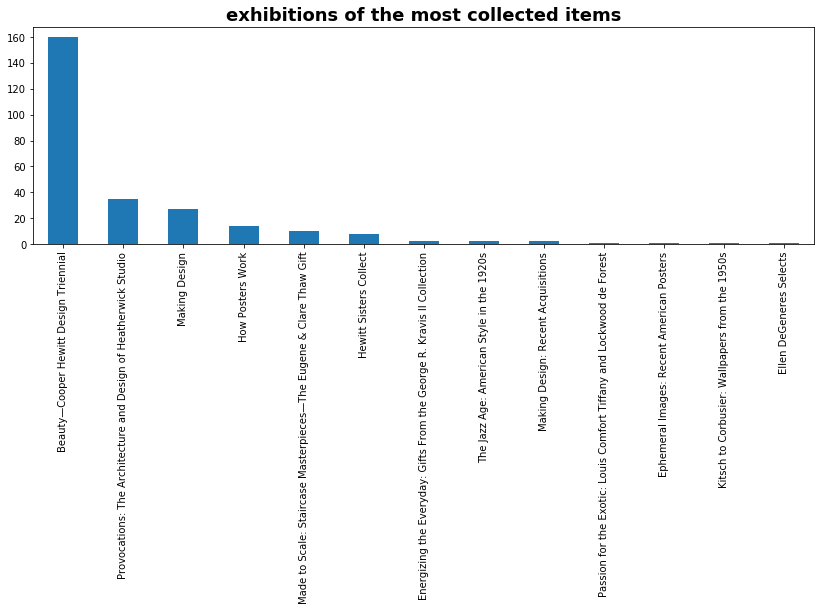

In [12]:
fig, ax = plt.subplots(figsize = (14,4))

top_exhibition = merged_date['exhibition_title'].value_counts()
top_exhibition.plot.bar(top_exhibition.index, y='exhibition_title', rot=0)
plt.xticks(rotation=90)
ax.set_title("Exhibition Title", size = 14)
plt.xticks(x=merged_date['exhibition_title'])
plt.title('exhibitions of the most collected items', fontdict={'fontweight': 'bold', 'fontsize':18})
# plt.savefig('exhibition_collected_items.png', dpi=300)

In [13]:
merged_date['exhibition_title'].value_counts()
top_exhibition.to_frame()

,exhibition_title
Beauty—Cooper Hewitt Design Triennial,160
Provocations: The Architecture and Design of Heatherwick Studio,35
Making Design,27
How Posters Work,14
Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,10
Hewitt Sisters Collect,8
Energizing the Everyday: Gifts From the George R. Kravis II Collection,2
The Jazz Age: American Style in the 1920s,2
Making Design: Recent Acquisitions,2
Passion for the Exotic: Louis Comfort Tiffany and Lockwood de Forest,1


In [17]:
merged_no_staircase_items = merged_date[~merged_date['exhibition_title'].str.contains('Staircase')]
#without the staircases

In [19]:
merged_no_staircase_items['object_id'].head(10)
#it's already sorted by nlargest

6      69192475
7      18733333
8      18187831
10     69155331
12     69172097
13     69172091
14     69172093
15     69172085
16    404529347
17     69172095
Name: object_id, dtype: object